In [ ]:
from random import gauss
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt

# Zad 1

In [ ]:
def pois_trajectory(l, n_jumps):
    return np.cumsum(expon.rvs(l, size=n_jumps))

def plot_pois_trajectory(l, n_jumps):
    jump_times = pois_trajectory(l, n_jumps)
    jump_times = np.repeat(jump_times, 2)
    jump_times = np.concatenate(([0.], jump_times[:-1]))
    
    jump_heights = np.array(range(n_jumps))
    jump_heights = np.repeat(jump_heights, 2)
    
    plt.plot(jump_times, jump_heights)
    plt.title("Poisson Process Trajectory")
    plt.legend([f"λ={l}, {n_jumps} jumps"])

In [ ]:
plot_pois_trajectory(0.5, 10)
plt.show()

In [ ]:
plot_pois_trajectory(0.5, 25)
plt.show()

# Zad 2

In [ ]:
def wiener_trajectory_simple(step, samples):
    return np.cumsum(np.sqrt(step) * np.random.normal(size=samples))

def wiener_with_linspace(from_t, to_t, samples):
    space, step = np.linspace(from_t, to_t, samples, retstep=True)
    return space, wiener_trajectory_simple(step, samples)

In [ ]:
plt.plot(*wiener_with_linspace(0.0, 1.0, 1000))
plt.show()

In [ ]:
#todo: cholesky

# Zad3

In [ ]:
def wiener_trajectory_multidim(dim, *args, **kwargs):
    return (wiener_trajectory_simple(*args, **kwargs) for _ in range(dim))

In [ ]:
plt.plot(*wiener_trajectory_multidim(2, step=0.01, samples=1000))
plt.show()

In [ ]:
plt.plot(*wiener_trajectory_multidim(2, step=0.001, samples=100_000))
plt.show()

In [ ]:
sample_count = 1000
w_x, w_y = wiener_trajectory_multidim(2, step=0.001, samples=sample_count)

%matplotlib notebook
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

def show_first_n(n):
    line.set_data(w_x[:n], w_y[:n])
    return line,

anim = animation.FuncAnimation(fig, show_first_n, frames=sample_count, interval=10, blit=True)

plt.show()

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
sc = ax.scatter([0],[0])

def show_nth(n):
    sc.set_offsets(
        np.hstack(([w_x[n]], [w_y[n]]))
    )
    return sc, 
    
anim = animation.FuncAnimation(fig, show_nth, frames=sample_count, interval=10, blit=True)

plt.show()

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

tail_len = 20

def show_tail(n):
    start = max(n-tail_len, 0)
    line.set_data(w_x[start:n], w_y[start:n])
    return line,

sc = ax.scatter([0],[0])

def show_nth(n):
    sc.set_offsets(
        np.hstack(([w_x[n]], [w_y[n]]))
    )
    return sc, 

def show_tail_and_dot(n):
    return show_tail(n), show_nth(n)


anim = animation.FuncAnimation(fig, show_tail_and_dot, frames=sample_count, interval=10, blit=True)
plt.show()

# Zad 4

In [ ]:
# todo: teoria

In [ ]:
%matplotlib inline

In [ ]:
def wiener_trajectory_2d_correlated(step, samples, correlation):
    w1, w2 = wiener_trajectory_multidim(2, step, samples)
    return w1, w1*correlation + np.sqrt(1-correlation*correlation) * w2

In [ ]:
plt.plot(*wiener_trajectory_2d_correlated(0.001, 10_000, 0.5), zorder=1)
plt.scatter([0], [0], color="red", zorder=2)
plt.show()

In [ ]:
plt.plot(*wiener_trajectory_2d_correlated(0.001, 10_000, 0.95), zorder=1)
plt.scatter([0], [0], color="red", zorder=2)
plt.show()

# Zad 5

In [5]:
variates_count = 1_000_000

In [45]:
from numba import njit
from random import random as uniform, seed as seed_rng, randint

def some_seed():
    return randint(-1_000_000, 1_000_000)

@njit
def mpwl_rvs(n):
    n1 = n + 1
    n2 = 2*np.sqrt(n1 * n1 * n1)
    n3 = 1/n2
    
    u = uniform()
    if u <= n3:
        return -n1
    elif u <= 2*n3:
        return n1
    else:
        return 0
    
@njit
def mpwl_cum_rvs(limit, seed=123):
    seed_rng(seed) # uwaga: numba ma thread-local seedy i czasami nie chce się zaseedować prawidłowo
    arr = np.zeros(limit)
    cum = 0
    for i in range(1, limit):
        cum += mpwl_rvs(i)
        arr[i] = float(cum) / float(i)
    return arr
    

In [56]:
%%timeit
np.cumsum(
    np.array(
        [mpwl_rvs(i) for i in range(1, variates_count)])
) / np.array([i for i in range(1, variates_count)])

428 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
mpwl_cum_rvs(variates_count, seed=some_seed())

34.7 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


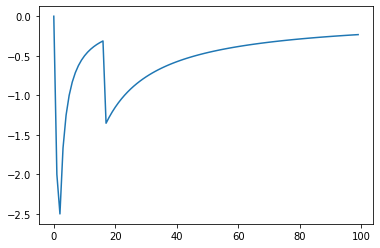

In [81]:
plt.plot(mpwl_cum_rvs(100, seed=some_seed()))
plt.show()

In [ ]:
for _ in range(10):
    plt.plot(mpwl_cum_rvs(variates_count, seed=some_seed()))
plt.plot([0, variates_count], [0, 0], color="black", lw=5)
plt.xlim(0, 100)
plt.show()

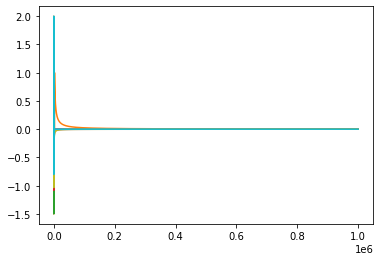

In [50]:
for _ in range(10):
    plt.plot(mpwl_cum_rvs(variates_count, seed=some_seed()))
plt.show()

In [ ]:
@njit
def spwl_rvs(n):
    n1 = n + 1
    n2 = 2*n1*np.log(n1) # ? div/0
    n3 = 1/n2 
    
    u = uniform()
    if u <= n3:
        return -n1
    elif u <= 2*n3:
        return n1
    else:
        return 0

In [ ]:
for _ in range(10):
    plt.plot(np.cumsum([spwl_rvs(i) for i in range(1, variates_count)]) /
             np.array([i for i in range(1, variates_count)]))
plt.show()